### Import Libraries

In [1]:
from netgen.geom2d import *
import scipy
import scipy.sparse.linalg
from ngsolve import *
from ngsolve.webgui import Draw
import numpy as np
from scipy.linalg import block_diag

import matplotlib.pyplot as plt

### Set Parameters

In [2]:
a = 2              # Length of rectangle in x direction 
b = 1             # Length of rectangle in y direction 
R = 1             # Radius of circle

maxh = 0.1   # Mesh-size
order = 4      # Order of Polynomials
nr_eigs = 200    # Number of Eigenvalues to approximate

### Create the Rectangle

In [3]:
geo = SplineGeometry()
geo.AddRectangle((0,0), (a,b), bcs=["b","r","t","l"])


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 1, 'order3d': 1, 'draw_vol': N…

### finite element space and bilinear form

In [4]:
fes = H1(mesh, complex=True, order=order)

eigenvec = GridFunction(fes,multidim=nr_eigs)

u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm (fes)
a += SymbolicBFI (grad(u)*grad(v))

b = BilinearForm (fes)
b += SymbolicBFI (u*v)

a.Assemble()
b.Assemble()

A=a.mat
B=b.mat

print(fes.ndof)


3769


### eigenvalue solver via scipy

In [5]:
shift = 3

shifted = a.mat.CreateMatrix()
shifted.AsVector().data = a.mat.AsVector() - (shift**2)*b.mat.AsVector()
invshifted = shifted.Inverse(freedofs=fes.FreeDofs())
print(a.mat.height)
tmp1 = eigenvec.vec.CreateVector()
tmp2 = eigenvec.vec.CreateVector()
def matvec(v):
    tmp1.FV().NumPy()[:] = v
    tmp2.data = b.mat * tmp1
    tmp1.data = invshifted * tmp2
    return tmp1.FV().NumPy()

A = scipy.sparse.linalg.LinearOperator( (a.mat.height,a.mat.width), matvec)
mu, vecs = scipy.sparse.linalg.eigs(A,nr_eigs)

lamsquared=shift**2+1/mu
lamsquared = sorted(lamsquared)
lams=[sqrt(l) for l in lamsquared]
print("resonances:")
for i in range (0,len(lams)):
    print(i,": ",lams[i], " squared: ", lamsquared[i])  


3769
resonances:
0 :  2.7637536810325694e-07  squared:  (7.638334409421077e-14-5.231654182198781e-16j)
1 :  1.5707963267949183  squared:  (2.467401100272408+1.9466459916763694e-15j)
2 :  3.1415926535915815  squared:  (9.869604401100593+5.083296250687346e-18j)
3 :  3.1415926535927103  squared:  (9.869604401107688+3.245315707195396e-16j)
4 :  3.5124073655270904  squared:  (12.337005501408957-2.8913401347786527e-16j)
5 :  4.442882938208045  squared:  (19.739208802620148-2.938824243897447e-15j)
6 :  4.712388980451828  squared:  (22.206609903083816-5.913755845441565e-15j)
7 :  5.663586700003694  squared:  (32.07621430845873+3.008435675400475e-15j)
8 :  6.283185308054069  squared:  (39.4784176153465-6.013775355831633e-15j)
9 :  6.283185308602233  squared:  (39.47841762223494-2.181294074747037e-15j)
10 :  6.476559173653017  squared:  (41.94581872982906-1.2488324621604285e-14j)
11 :  7.024814733834509  squared:  (49.3480220446984-4.922021451147236e-15j)
12 :  7.024814734721553  squared:  (49.3

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


### copy and plot eigenfunctions

In [6]:
for i in range(nr_eigs):
    eigenvec.vecs[i].FV().NumPy()[:] = vecs[:,i]

Draw(eigenvec)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'draw_vol': F…

In [7]:
def QR_simple(A,tol = 1e-6):
    count = 0
    while abs(A[1,0]) > tol:
        Q,R = np.linalg.qr(A)
        A = R@Q
        count +=1
    return A, sorted(np.diag(A)) ,count



def QR_shift(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol:
            rho = A[i,i]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count +=1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_shift2(A,tol=1e-6):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_hesse(A,tol=1e-13):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A))[::-1], count



def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)

    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
            
        M = np.array([[c.conj(), s.conj()], [-s, c]])
        G = block_diag(np.eye(i,i), M, np.eye(n-i-2, n-i-2))
        Q = G@Q
        for j in range(i, n):
            temp_1 = A[i,j]
            A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
            A[i+1,j] = -s*temp_1 + c*A[i+1,j]
    return Q.T.conj(), A



def lanczos(A,k = 0):
    n = A.shape[1]
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    gam = [v[0].T.conj()@A@v[0]]
    w = (A - gam[0]*np.identity(n))@v[0]
    delta = [np.linalg.norm(w)]
    i = 0
    while delta[i] > 1e-12 and i<k-1:
        v.append(w/delta[i])
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)



def arnoldi(A, dim, k = 0):
    n = dim
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    h = np.zeros((k,k))
    
    for j in range(k):
        w = A(v[j])
        for l in range(j+1):
            h[l][j] = v[l].T.conj()@w
            w = w - h[l][j]*v[l]
        if j < k-1:
            h[j+1][j] = np.sqrt(w.T.conj()@w)
            if abs(h[j+1][j]) < 1e-14:
                return QR_hesse(h[:j+1,:j+1])
            else:
                v.append(w/h[j+1][j])
    
    return QR_hesse(h)

In [8]:
mu = arnoldi(A, a.mat.height, nr_eigs)[1]

for i in range(len(mu)):
    mu[i] = shift**2+1/mu[i]
lamsquared_1 = mu
lamsquared_1 = sorted(lamsquared_1)
lams_1= [sqrt(l) for l in lamsquared_1]
print("resonances:")
for i in range (0,len(lams_1)):
    print(i,": ",lams_1[i], " squared: ", lamsquared_1[i])  


C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: ComplexWarning: Casting complex values to real discards the imaginary part


resonances:
0 :  5.960464477539063e-08  squared:  (3.552713678800501e-15-1.0644943565053585e-28j)
1 :  1.5707963267948948  squared:  (2.467401100272334+8.825087945635799e-24j)
2 :  3.141592653591582  squared:  (9.869604401100597-8.887734481880842e-26j)
3 :  3.1415926535927112  squared:  (9.869604401107692-2.238848295002549e-25j)
4 :  3.5124073655270935  squared:  (12.337005501408978+5.75764922433751e-25j)
5 :  4.442882938208057  squared:  (19.73920880262026+7.15488639807855e-23j)
6 :  4.712388980451836  squared:  (22.206609903083894+1.082036810232261e-22j)
7 :  5.663586700003702  squared:  (32.076214308458816+5.506146298696327e-23j)
8 :  6.2831853080540645  squared:  (39.47841761534645-2.688061246418741e-22j)
9 :  6.283185308602179  squared:  (39.478417622234254-3.844974790448096e-22j)
10 :  6.476559173652933  squared:  (41.94581872982796-4.15071596889316e-22j)
11 :  7.024814733834523  squared:  (49.3480220446986-1.0837004913395781e-21j)
12 :  7.024814734721575  squared:  (49.348022057

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


In [9]:
def err(A,B,k=0):
    if k == 0:
        k = len(A)
    print(np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1))
    
def plot_err(A,B,k=0):
    if k == 0:
        k = len(A)
    return np.linalg.norm(np.array(A[:k])-np.array(B[:k]), ord = 1)

def plot_err_1(A,B,k):
    return abs(np.array(A[k])-np.array(B[k]))

In [10]:
def exact_eigvals(n,m):
    return np.pi**2*((n**2)/4 + m**2)

exact_arr = []

for n in range(50):
    for m in range(20):
        exact_arr.append(exact_eigvals(n,m))
        
exact_arr = sorted(exact_arr)
exact_arr = exact_arr[:int(nr_eigs*0.45)]

<IPython.core.display.Javascript object>


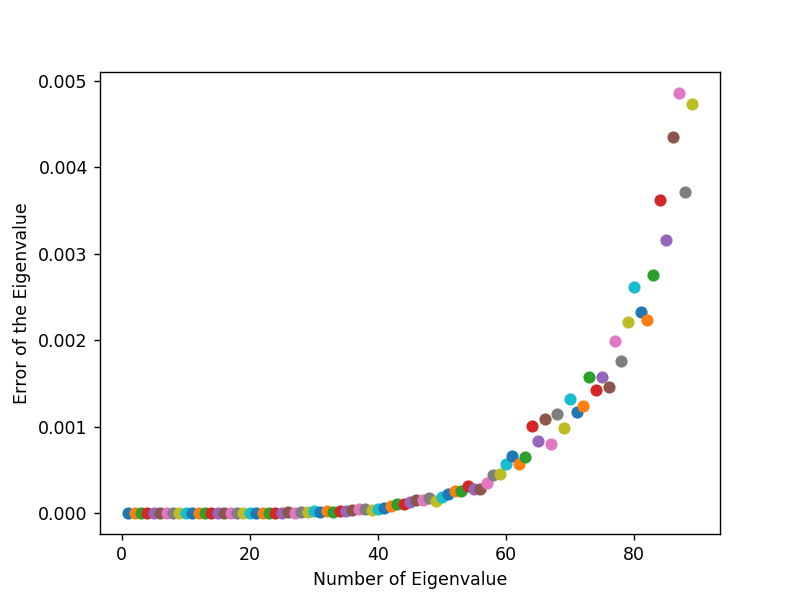

In [11]:
%matplotlib notebook

for k in range(1,int(nr_eigs*0.45)):
    plt.plot(k,plot_err_1(exact_arr, lamsquared_1,k), 'o')

plt.xlabel("Number of Eigenvalue")
plt.ylabel("Error of the Eigenvalue")
plt.show()